In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
from pathlib import Path
from tqdm.notebook import tqdm
import os

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# Q1.1: Data Transformation

In [4]:
def round_time(time: str) -> str:
    """
    Round the time to the next hour.
    This function takes a time string in the format "HH:MM" and rounds it to the next hour.
    For example, "12:15" will be rounded to "13:00", and "12:00" will remain "12:00".
    Args:
        time (str): _description_

    Returns:
        str: _description_
    """
    data = time.split(":")
    hour = int(data[0])
    minute = int(data[1])
    hour = hour + 1 if minute > 0 else hour
    return f"{hour:02d}:00"

In [5]:
def add_missing_times(df):
    full_range = [f"{i:02d}:00" for i in range(49)] 
    
    # Create empty DataFrame with complete timeline
    full_df = pd.DataFrame({'Time': full_range})
    
    # Merge with original data
    merged = pd.merge(full_df, df, on='Time', how='left')
    
    return merged

In [6]:
# Create a dictionary to map the columns to their respective aggregation functions

d = {
    'Age': "last",
    'BUN': "max", 
    'Creatinine': "max", 
    'GCS': "min",
    'Gender': "last", 
    'Glucose': "max",  
    'HCO3': "min",
    'HCT': "min", 
    'HR': "max", 
    'Height': "last", 
    'ICUType': "last", 
    'K': "last", 
    'Mg': "last", 
    'NIDiasABP': "mean", 
    'NIMAP': "mean",
    'NISysABP': "mean", 
    'Na': "min", 
    'Platelets': "min", 
    'RecordID': "last", 
    'RespRate': "max", 
    'Temp': "max",
    'TroponinT': "max", 
    'Urine': "sum", 
    'WBC': "max", 
    'Weight': "last", 
    'ALP': "max", 
    'ALT': "max", 
    'AST': "max", 
    'Albumin': "min",
    'Bilirubin': "max", 
    'FiO2': "last", 
    'MechVent': "last", 
    'PaCO2': "max", 
    'PaO2': "max", 
    'pH': "min", 
    'DiasABP': "mean",
    'MAP': "mean", 
    'SaO2': "min", 
    'SysABP': "mean", 
    'Lactate': "max", 
    'Cholesterol': "last", 
    'TroponinI': "max"
}

# Create a new list of columns in the desired order, i.e., first the static variables followed by the dynamic variables
static_variables = ["Time", "RecordID", "Age", "Gender", "Height", "Weight", "ICUType"]
new_order = static_variables + list(set(d.keys()).difference(set(static_variables)))

In [7]:
# For the three provided datasets we perfrorm the following steps: 
for _set in ["a", "b", "c"]:
    
    # hold the new dataframes in a list
    pivoted_list = []
    for file in Path(f'../data/set-{_set}').glob('*.txt'):
        
        #read each file into a dataframe
        df = pd.read_csv(file)
        
        # apply the rounding function to the Time column
        df["Time"] = df.Time.apply(round_time)
        
        # pivot the dataframe so that all variables are in columns and apply the aggregation functions
        pivoted = df.pivot_table(index='Time', columns='Parameter', values='Value', aggfunc=["sum", "mean", "last", "min", "max"]).reset_index()
        
        # rename the columns base on the aggregation functions
        pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
        pivoted = pivoted[["Time_"] + [f"{v}_{k}" for k, v in d.items() if f"{v}_{k}" in pivoted.columns]]
        
        # remove the prefixes from the columns
        pivoted.columns = [col.split("_")[1] if col != "Time_" else col[:-1] for col in pivoted.columns]
        
        # add missing time rows
        pivoted = add_missing_times(pivoted)
        
        # add the RecordID
        pivoted['RecordID'] = pivoted['RecordID'].iloc[0]
        
        # save the pivoted dataframe into a list
        pivoted_list.append(pivoted)
        
    # concatenating all the pivoted dataframes into one
    dataset = pd.concat(pivoted_list).reset_index(drop=True)
    
    # simplify the RECORD ID values
    dataset["RecordID"] = dataset["RecordID"].astype(int)
    
    # apply the new order to the columns
    dataset = dataset[new_order]
    
    # add the outcome column
    outcomes = pd.read_csv(f"../data/Outcomes-{_set}.txt")
    outcomes = outcomes[["RecordID", "In-hospital_death"]]
    dataset = dataset.set_index("RecordID").join(outcomes.set_index("RecordID")).reset_index()
    
    # write the new dataset to a parquet file
    dataset.to_parquet(f"../data/set-{_set}.parquet", index=False)

# Q1.2 Exploratory Data Analysis

In [8]:
dataset_a = pd.read_parquet("../data/set-a.parquet")

<AxesSubplot:xlabel='In-hospital_death', ylabel='count'>

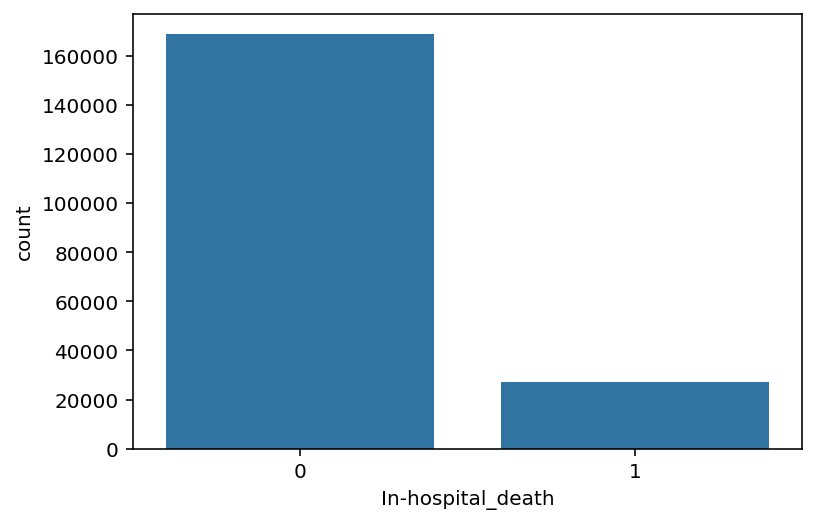

In [9]:
sns.countplot(x="In-hospital_death", data=dataset_a)

# Q1.3 Preprocess data for Machine Learning

## Simple forward fill for the missing values

In [10]:
train = pd.read_parquet("../data/set-a.parquet")
validation = pd.read_parquet("../data/set-b.parquet")
test = pd.read_parquet("../data/set-c.parquet")

- add the missing row when necassary so that every patient has the same number of rows
- perform the feedforward imputation 
- for the remaining values impute using the mean of the colmn

In [11]:
filled_train = train.groupby('RecordID').ffill()
filled_train["RecordID"] = train.RecordID
filled_train

,Time,Age,Gender,Height,Weight,ICUType,Bilirubin,Lactate,PaCO2,Cholesterol,...,RespRate,NIDiasABP,MAP,Platelets,NIMAP,FiO2,HR,HCO3,In-hospital_death,RecordID
0,00:00,54.0,0.0,-1.0,-1.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,132539
1,01:00,54.0,0.0,-1.0,-1.0,4.0,NaN,NaN,NaN,NaN,...,19.0,61.5,NaN,NaN,91.665,NaN,77.0,NaN,0,132539
2,02:00,54.0,0.0,-1.0,-1.0,4.0,NaN,NaN,NaN,NaN,...,18.0,62.0,NaN,NaN,87.000,NaN,60.0,NaN,0,132539
3,03:00,54.0,0.0,-1.0,-1.0,4.0,NaN,NaN,NaN,NaN,...,19.0,52.0,NaN,NaN,75.670,NaN,62.0,NaN,0,132539
4,04:00,54.0,0.0,-1.0,-1.0,4.0,NaN,NaN,NaN,NaN,...,20.0,52.0,NaN,NaN,72.670,NaN,80.0,NaN,0,132539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,78.0,0.0,157.5,87.3,4.0,0.5,1.8,40.0,NaN,...,NaN,87.0,75.0,82.0,90.000,0.5,120.0,19.0,0,142673
195996,45:00,78.0,0.0,157.5,87.3,4.0,0.5,1.8,40.0,NaN,...,NaN,55.0,71.5,82.0,63.000,0.5,92.0,19.0,0,142673
195997,46:00,78.0,0.0,157.5,87.3,4.0,0.5,1.8,40.0,NaN,...,NaN,82.0,73.0,82.0,92.000,0.5,85.0,19.0,0,142673
195998,47:00,78.0,0.0,157.5,87.3,4.0,0.5,1.8,40.0,NaN,...,NaN,67.0,80.0,82.0,83.000,0.5,86.0,19.0,0,142673


In [12]:
numerical_features = filled_train.drop(columns=["RecordID", "Time", "Gender", "ICUType", "MechVent"])
numerical_features_mean = numerical_features.mean()

numerical_features.fillna(numerical_features_mean, inplace=True)
numerical_features[["RecordID", "Time", "Gender", "ICUType", "MechVent"]] = filled_train[["RecordID", "Time", "Gender", "ICUType", "MechVent"]]
filled_train = numerical_features.fillna(-1)
filled_train = filled_train[new_order +  ["In-hospital_death"]]
filled_train

,Time,RecordID,Age,Gender,Height,Weight,ICUType,Bilirubin,Lactate,PaCO2,...,TroponinT,RespRate,NIDiasABP,MAP,Platelets,NIMAP,FiO2,HR,HCO3,In-hospital_death
0,00:00,132539,54.0,0.0,-1.0,-1.0,4.0,2.010439,2.206357,40.156219,...,1.056302,19.877148,57.58772,81.026753,205.438863,76.411843,0.51966,87.248902,23.574313,0
1,01:00,132539,54.0,0.0,-1.0,-1.0,4.0,2.010439,2.206357,40.156219,...,1.056302,19.000000,61.50000,81.026753,205.438863,91.665000,0.51966,77.000000,23.574313,0
2,02:00,132539,54.0,0.0,-1.0,-1.0,4.0,2.010439,2.206357,40.156219,...,1.056302,18.000000,62.00000,81.026753,205.438863,87.000000,0.51966,60.000000,23.574313,0
3,03:00,132539,54.0,0.0,-1.0,-1.0,4.0,2.010439,2.206357,40.156219,...,1.056302,19.000000,52.00000,81.026753,205.438863,75.670000,0.51966,62.000000,23.574313,0
4,04:00,132539,54.0,0.0,-1.0,-1.0,4.0,2.010439,2.206357,40.156219,...,1.056302,20.000000,52.00000,81.026753,205.438863,72.670000,0.51966,80.000000,23.574313,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,142673,78.0,0.0,157.5,87.3,4.0,0.500000,1.800000,40.000000,...,1.056302,19.877148,87.00000,75.000000,82.000000,90.000000,0.50000,120.000000,19.000000,0
195996,45:00,142673,78.0,0.0,157.5,87.3,4.0,0.500000,1.800000,40.000000,...,1.056302,19.877148,55.00000,71.500000,82.000000,63.000000,0.50000,92.000000,19.000000,0
195997,46:00,142673,78.0,0.0,157.5,87.3,4.0,0.500000,1.800000,40.000000,...,1.056302,19.877148,82.00000,73.000000,82.000000,92.000000,0.50000,85.000000,19.000000,0
195998,47:00,142673,78.0,0.0,157.5,87.3,4.0,0.500000,1.800000,40.000000,...,1.056302,19.877148,67.00000,80.000000,82.000000,83.000000,0.50000,86.000000,19.000000,0


In [13]:
filled_train.to_parquet("../data/set-a-filled.parquet", index=False)

In [14]:
filled_val = validation.groupby('RecordID').ffill()
filled_val["RecordID"] = validation.RecordID
filled_val

,Time,Age,Gender,Height,Weight,ICUType,Bilirubin,Lactate,PaCO2,Cholesterol,...,RespRate,NIDiasABP,MAP,Platelets,NIMAP,FiO2,HR,HCO3,In-hospital_death,RecordID
0,00:00,70.0,1.0,175.3,85.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,142675
1,01:00,70.0,1.0,175.3,85.0,2.0,NaN,NaN,32.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,142675
2,02:00,70.0,1.0,175.3,85.0,2.0,NaN,NaN,25.0,NaN,...,NaN,NaN,92.0,NaN,NaN,1.0,76.0,NaN,1,142675
3,03:00,70.0,1.0,175.3,85.0,2.0,NaN,NaN,25.0,NaN,...,NaN,NaN,89.2,185.0,NaN,0.5,85.0,22.0,1,142675
4,04:00,70.0,1.0,175.3,85.0,2.0,NaN,NaN,33.0,NaN,...,NaN,NaN,73.5,185.0,NaN,0.5,95.0,22.0,1,142675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,82.0,0.0,-1.0,-1.0,2.0,NaN,1.3,42.0,NaN,...,NaN,NaN,70.0,137.0,NaN,0.4,63.0,21.0,0,152864
195996,45:00,82.0,0.0,-1.0,-1.0,2.0,NaN,1.3,42.0,NaN,...,NaN,NaN,68.0,137.0,NaN,0.4,60.0,21.0,0,152864
195997,46:00,82.0,0.0,-1.0,-1.0,2.0,NaN,1.3,42.0,NaN,...,NaN,NaN,59.0,137.0,NaN,0.4,60.0,21.0,0,152864
195998,47:00,82.0,0.0,-1.0,-1.0,2.0,NaN,1.3,42.0,NaN,...,NaN,NaN,55.0,137.0,NaN,0.4,59.0,21.0,0,152864


In [15]:
numerical_features = filled_val.drop(columns=["RecordID", "Time", "Gender", "ICUType", "MechVent"])

numerical_features.fillna(numerical_features_mean, inplace=True)
numerical_features[["RecordID", "Time", "Gender", "ICUType", "MechVent"]] = filled_val[["RecordID", "Time", "Gender", "ICUType", "MechVent"]]
filled_val = numerical_features.fillna(-1)
filled_val = filled_val[new_order +  ["In-hospital_death"]]
filled_val

,Time,RecordID,Age,Gender,Height,Weight,ICUType,Bilirubin,Lactate,PaCO2,...,TroponinT,RespRate,NIDiasABP,MAP,Platelets,NIMAP,FiO2,HR,HCO3,In-hospital_death
0,00:00,142675,70.0,1.0,175.3,85.0,2.0,2.010439,2.206357,40.156219,...,1.056302,19.877148,57.58772,81.026753,205.438863,76.411843,0.51966,87.248902,23.574313,1
1,01:00,142675,70.0,1.0,175.3,85.0,2.0,2.010439,2.206357,32.000000,...,1.056302,19.877148,57.58772,81.026753,205.438863,76.411843,0.51966,87.248902,23.574313,1
2,02:00,142675,70.0,1.0,175.3,85.0,2.0,2.010439,2.206357,25.000000,...,1.056302,19.877148,57.58772,92.000000,205.438863,76.411843,1.00000,76.000000,23.574313,1
3,03:00,142675,70.0,1.0,175.3,85.0,2.0,2.010439,2.206357,25.000000,...,1.056302,19.877148,57.58772,89.200000,185.000000,76.411843,0.50000,85.000000,22.000000,1
4,04:00,142675,70.0,1.0,175.3,85.0,2.0,2.010439,2.206357,33.000000,...,1.056302,19.877148,57.58772,73.500000,185.000000,76.411843,0.50000,95.000000,22.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,152864,82.0,0.0,-1.0,-1.0,2.0,2.010439,1.300000,42.000000,...,1.056302,19.877148,57.58772,70.000000,137.000000,76.411843,0.40000,63.000000,21.000000,0
195996,45:00,152864,82.0,0.0,-1.0,-1.0,2.0,2.010439,1.300000,42.000000,...,1.056302,19.877148,57.58772,68.000000,137.000000,76.411843,0.40000,60.000000,21.000000,0
195997,46:00,152864,82.0,0.0,-1.0,-1.0,2.0,2.010439,1.300000,42.000000,...,1.056302,19.877148,57.58772,59.000000,137.000000,76.411843,0.40000,60.000000,21.000000,0
195998,47:00,152864,82.0,0.0,-1.0,-1.0,2.0,2.010439,1.300000,42.000000,...,1.056302,19.877148,57.58772,55.000000,137.000000,76.411843,0.40000,59.000000,21.000000,0


In [16]:
filled_val.to_parquet("../data/set-b-filled.parquet", index=False)

In [17]:
filled_test = test.groupby('RecordID').ffill()
filled_test["RecordID"] = test.RecordID
filled_test

,Time,Age,Gender,Height,Weight,ICUType,Bilirubin,Lactate,PaCO2,Cholesterol,...,RespRate,NIDiasABP,MAP,Platelets,NIMAP,FiO2,HR,HCO3,In-hospital_death,RecordID
0,00:00,71.0,1.0,167.6,79.2,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,152871
1,01:00,71.0,1.0,167.6,79.2,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,92.000000,NaN,NaN,0.4,69.0,NaN,0,152871
2,02:00,71.0,1.0,167.6,79.2,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,75.666667,NaN,NaN,0.4,66.0,20.0,0,152871
3,03:00,71.0,1.0,167.6,79.2,4.0,NaN,NaN,42.0,NaN,...,NaN,NaN,92.000000,NaN,NaN,0.4,66.0,20.0,0,152871
4,04:00,71.0,1.0,167.6,79.2,4.0,NaN,NaN,42.0,NaN,...,NaN,NaN,92.000000,NaN,NaN,0.4,66.0,20.0,0,152871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,74.0,0.0,-1.0,73.1,1.0,0.8,0.9,32.0,143.0,...,NaN,55.0,72.000000,181.0,67.0,0.5,85.0,17.0,0,163037
195996,45:00,74.0,0.0,-1.0,73.1,1.0,0.8,0.9,32.0,143.0,...,NaN,55.0,72.000000,181.0,67.0,0.5,85.0,17.0,0,163037
195997,46:00,74.0,0.0,-1.0,73.1,1.0,0.8,0.9,32.0,143.0,...,NaN,51.0,85.000000,181.0,61.0,0.5,88.0,17.0,0,163037
195998,47:00,74.0,0.0,-1.0,73.1,1.0,0.8,0.9,32.0,143.0,...,NaN,51.0,64.000000,181.0,61.0,0.5,71.0,17.0,0,163037


In [18]:
numerical_features = filled_test.drop(columns=["RecordID", "Time", "Gender", "ICUType", "MechVent"])

numerical_features.fillna(numerical_features_mean, inplace=True)
numerical_features[["RecordID", "Time", "Gender", "ICUType", "MechVent"]] = filled_test[["RecordID", "Time", "Gender", "ICUType", "MechVent"]]
filled_test = numerical_features.fillna(-1)
filled_test = filled_test[new_order +  ["In-hospital_death"]]
filled_test

,Time,RecordID,Age,Gender,Height,Weight,ICUType,Bilirubin,Lactate,PaCO2,...,TroponinT,RespRate,NIDiasABP,MAP,Platelets,NIMAP,FiO2,HR,HCO3,In-hospital_death
0,00:00,152871,71.0,1.0,167.6,79.2,4.0,2.010439,2.206357,40.156219,...,1.056302,19.877148,57.58772,81.026753,205.438863,76.411843,0.51966,87.248902,23.574313,0
1,01:00,152871,71.0,1.0,167.6,79.2,4.0,2.010439,2.206357,40.156219,...,1.056302,19.877148,57.58772,92.000000,205.438863,76.411843,0.40000,69.000000,23.574313,0
2,02:00,152871,71.0,1.0,167.6,79.2,4.0,2.010439,2.206357,40.156219,...,1.056302,19.877148,57.58772,75.666667,205.438863,76.411843,0.40000,66.000000,20.000000,0
3,03:00,152871,71.0,1.0,167.6,79.2,4.0,2.010439,2.206357,42.000000,...,1.056302,19.877148,57.58772,92.000000,205.438863,76.411843,0.40000,66.000000,20.000000,0
4,04:00,152871,71.0,1.0,167.6,79.2,4.0,2.010439,2.206357,42.000000,...,1.056302,19.877148,57.58772,92.000000,205.438863,76.411843,0.40000,66.000000,20.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,163037,74.0,0.0,-1.0,73.1,1.0,0.800000,0.900000,32.000000,...,0.190000,19.877148,55.00000,72.000000,181.000000,67.000000,0.50000,85.000000,17.000000,0
195996,45:00,163037,74.0,0.0,-1.0,73.1,1.0,0.800000,0.900000,32.000000,...,0.190000,19.877148,55.00000,72.000000,181.000000,67.000000,0.50000,85.000000,17.000000,0
195997,46:00,163037,74.0,0.0,-1.0,73.1,1.0,0.800000,0.900000,32.000000,...,0.190000,19.877148,51.00000,85.000000,181.000000,61.000000,0.50000,88.000000,17.000000,0
195998,47:00,163037,74.0,0.0,-1.0,73.1,1.0,0.800000,0.900000,32.000000,...,0.190000,19.877148,51.00000,64.000000,181.000000,61.000000,0.50000,71.000000,17.000000,0


In [19]:
filled_test.to_parquet("../data/set-c-filled.parquet", index=False)

In [81]:
# TODO: Data should be normalized after Q1.2